# Analyze contact interactions of Hv1-2GBI system.

By: Victoria Lim  
Last updated: 2018-03-01

This notebook processes the pickled pandas dataframe of contact interactions from node-edge interactions processed in VMD.  
Pickle file details:
- Generated from: `/beegfs/DATA/mobley/limvt/hv1/04_fep/postFEPvanilla/analysis/3_nonCovInts/nodeContacts.py`
- Pickle dump line: `pickle.dump((nodes, edges), open( pickleOut, "wb" ) )`

**Notebook inputs**:  
Nodes and edges are pandas dataframes as generated in the above script.
- Node example:
  - TODO

- Node details:
  - TODO



- Edge example:

||node_i | node_j | weight | attribute | count | average |
------------------------------------------------------- |
|34647 |	165 | 174 |	132 |	HPHOB | 97.0 | 1.360825 |
|34648 |	165	| 175 | 322 |	HPHOB | 130.0 | 2.476923 |

- Edge details:
  - First column is the pandas dataframe index. This value is not significant.
  - `node_i`: TODO -- include notes from README and reference for Benson&Daggett
  - `node_j`: The node interacting with `node_i`. The value of `node_j` should always be greater than or equal to that of `node_i`.
  - `weight`: Each node has a variable number of atoms. The weight of an interaction is the number of interactions for the atoms in `node_i` to the atoms in `node_j`. The weight listed is the sum over all frames of the weights found for this node pair.
  - `attribute`
  - `count`: Number of trajectory frames this edge interaction was found.
  - `average`: This is taken as the quotient of `weight`/`count`.

**Troubleshooting**:
* If you subtract two edge dataframes and lose most interactions, it might be that the node indices don't match up.   
  * For example, let's say dataframe_1 has the node_35 to node_99 interaction as an HBOND,  
but dataframe_2 shows the node_35 to node_99 interaction as COUL (Coulombic) interaction.  
There was a mutation associated with dataframe_2, which knocked out 5 nodes, starting at node_80.  
Then the real match of dataframe_1's node_35 to node_99 for dataframe_2 is with node_35 to node_94.  
  * This _shouldn't_ be an issue since the `diffEdges` function should take out any edge involving  
any mutation-related notes, and then scale the rest of the edges by that offset.  
(By the way, this function does have a pretty limited use-case currently, so check the documentation.)
  * To determine if this is the case, look for the line:  
`diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j','attribute'],how='inner')`  
(or the analogus merge line), and take out the requirement to match on attribute as well as on nodes:  
`diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j',],how='inner')`.  
Print and scrutinize the resulting edges dataframe, such as using `head()`, `tail()` or `iloc[range1:range2]`.

* If you `.apply` some function to a pandas dataframe column and get some error:  
Try iterating over the column and applying that function one-by-one to look for the bug.  
`for i, (index, row) in enumerate(diff_edges_1.iterrows()):`

* If you see `SettingWithCopyWarning`, it's probably because you're altering some dataframe that's likely a copy of the original. That might be fine if you have just one change to make (e.g., I was able to increment all of `node_i`). However, if you have to work with it further, then consider wrangling with `.loc` (or similar) functions for modifying the bona fide dataframe (e.g., when I then tried to increment `node_j`, the original changes to `node_i` were gone).

**References**:
TODO

**Questions to self**:
* For a heat map of edge differences, such as before and after mutation, what cutoff is significant? Do you notice in the trajectory, for example, when the data says the interaction between F150 and 2GBI:benzo decreases by '-5'?

___________________________________________________________________


**TODO for R211S**:
* interactions of d112 d185 (before and after) (waters?)


**TODO**: 
* subtract edges for 2GBI taut2 and taut1 by connecting benzo--benzo, guan--guan, CNN--(NN+CN)
* make WATERS general enough to see which residues have most overall contact with any water?
* update function documenation to numpy format
   * https://github.com/numpy/numpydoc/blob/master/doc/example.py
   * https://samnicholls.net/2016/06/15/how-to-sphinx-readthedocs/
* make the heatplot a 3D plot colored by inttype (e.g., COUL)
* is it valid to subtract edge data when the averages may have come from different-length trajectories?

**Table of Contents**  

1. Load in data  
    1. Demonstrate some functions defined in this notebook
2. Analyze interactions before and after mutation of R211S
    1. Focus on whole protein-ligand system
    1. Focus on ligand-specific interactions
        1. Tautomer 1
        2. Tautomer 2
        3. No ligand
    1. Focus on other defined interactions
3. Analyze interactions differentiating tautomers
    1. Focus on whole protein-ligand system
        1. After mutation
        2. Before mutation
    1. Focus on ligand-specific interactions
        1. After mutation
        2. Before mutation
4. Analyze interactions directly from computed edges
    1. Focus on whole protein-ligand system
        1. After mutation
            1. Tautomer 1
            1. Tautomer 2
        2. Before mutation
5. Troubleshooting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns # heatmap with pandas

#%matplotlib inline
#%matplotlib notebook
np.__file__

'/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'

In [2]:
def getEdgePair(node1, node2, edges):
    """
    
    Notes
    -----
    Can't find the interaction you're looking for? Might need to
    add/subtract an offset if you used the diffEdges function. 
    The offset value (with sign and magnitude) should have been
    printed out: "Shifting node indices by..."
    
    """
    return edges[(edges.node_i == node1) & (edges.node_j == node2)]

def findInEdges(nodeNum, edges, att=None):
    """
    """
    if att is not None:
        return edges[(edges.attribute == att) & ((edges.node_i == nodeNum) | (edges.node_j == nodeNum))]
    else:
        return edges[(edges.node_i == nodeNum) | (edges.node_j == nodeNum)]
    

def getResidInfo(resid, nodes, resExcludes=[]):
    """
    Get the node information for specified protein residue index.
    
    Parameters
    ----------
    nodes: pandas dataframe of nodes
    resid: integer value of the protein residue index
    resExcludes: list of strings, for each residues to ignore.
                 e.g., ['WAT']
    Returns
    -------
    nodes_id: pandas dataframe with only residue of interest
    
    """
    nodes_id = nodes.loc[nodes['resid'] == resid]
    nodes_id = nodes_id[~nodes_id.resname.isin(resExcludes)]

    return nodes_id



def idxToResid(idx, nodes, idOnly=False):
    """
    This function takes in some node index and generates 
    a string code of one-letter residue name and integer of residue number.
    
    Parameters
    ----------
    idx    | int       | integer index of the pandas dataframe
    nodes  | pandas df | pandas dataframe of which to search
    idOnly | Bool      | specify True to return numpy.int64 of residue number
                         specify False to return code with resname abbrev
                         ex., True returns 150; False returns 'F150:sc'
    Returns
    -------
    code - string or numpy.int64 value of residue. (see idOnly parameter)
    
    """
    aa_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'HSD': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M',
     'GBI1':'GBI1', 'GBI2':'GBI2', 'WAT':'WAT'}
    
    #old way not conducive to taking diff of dataframes
    #entry = nodes.iloc[idx-1]
    entry = nodes.loc[nodes.index == idx] # iloc gives series, loc gives dataframe
    entry = entry.T.squeeze() # convert from dataframe to series
    resname = entry['resname']
    if resname in ['GBI1','GBI2']:
        code = aa_dict[resname]+':'+entry['code']
    elif resname == 'WAT':
        code = aa_dict[resname]+str(entry['resid'])
    else: # if not GBI or WAT, must be Hv1
        if idOnly: code = entry['resid']
        else: code = aa_dict[resname]+str(entry['resid'])+':'+entry['location']       

    return code

In [3]:
def prioritizeOrPivot(edges, prioritize=True, rawNum=None):
    """
    Pull out N strongest interactions, or pivot the table.
    Not meant for user; implemented in protLigInts and selectionInts functions.
    This function handles cases of whether dataframe has edges or difference of edges.
    """
    if prioritize:
        if rawNum is None:
            print("ERROR: rawNum variable was not passed into prioritizeOrPivot function")
            return None
        try: # Pull out the N strongest interactions (should be no negative values)
            edges = edges.sort_values('average',ascending=False).head(rawNum)
        except KeyError: # if no 'average' column then this is one df minus another so there are negatives
            # sort by magnitude to get + and - changes
            tempinds = edges.avg_subt.abs().sort_values(ascending=False).head(rawNum).index
            edges = edges.loc[tempinds]
        return edges
    
    else: # pivot table for plotting
        try:
            edges = edges.pivot(index='node_i',columns='node_j', values='average')
        except KeyError:
            edges = edges.pivot(index='node_i',columns='node_j', values='avg_subt')
        edges = edges.dropna(axis=1,how='all') # drop columns with all nan's
        return edges

def protLigInts(nodes, edges, rawNum=250):
    """
    Take in a set of nodes and edges and identify the N strongest interactions.
    This function disregards:
      (1) interactions between waters (there can be protein-water interaction),
      (2) interactions between adjacent residues (e.g., residue F149 and F150), and
      (3) interactions within the same residue (e.g., backbone and sidechain of F150).
      
    Parameters
    ----------
    nodes   | pandas df | pandas dataframe with information on nodes (residues)
    edges   | pandas df | pandas dataframe with information on edges (contacts)
    rawNum  | int       | How many interactions to use before further processing. 
                          Further processing = remove adjacent & intra-residue interactions.
    Returns
    -------
    watless_edges - pandas PIVOTED dataframe with reduced and filtered interactions
                    new format:
                     > node_i as index column
                     > node_j as different columns
                     > average interaction strength in cell intersecting node_i and node_j
    
    """
    # Get all indices of nodes that are not water
    watless_idx = nodes.index[nodes['resname'] != 'WAT'].tolist()
    # Get edge interactions that involve no waters
    watless_edges = edges.loc[edges['node_i'].isin(watless_idx) | edges['node_j'].isin(watless_idx)]
    
    # Pull out the N strongest interactions
    watless_edges = prioritizeOrPivot(watless_edges,prioritize=True,rawNum=rawNum)
    if watless_edges is None: return
    
    # Make temp copy to compare protein resIDs to filter out those in same/adj resid
    temp = watless_edges.copy()
    temp['node_i'] = temp['node_i'].apply(idxToResid,args=(nodes,True))
    temp['node_j'] = temp['node_j'].apply(idxToResid,args=(nodes,True))
    # convert the non-protein residues with no ID for temp integer
    temp['node_i'].replace('GBI\w', -500, regex=True,inplace=True)
    temp['node_j'].replace('GBI\w', -500, regex=True,inplace=True)
    temp['node_i'].replace('WAT\w', -400, regex=True,inplace=True)
    temp['node_j'].replace('WAT\w', -400, regex=True,inplace=True)
    
    # drop node interactions in same resid or adjacent
    dropinds = temp.index[((temp['node_i']-temp['node_j']).abs() <= 1) == True].tolist()
    watless_edges.drop(dropinds, inplace=True)

    # pivot table for plotting
    watless_edges = prioritizeOrPivot(watless_edges,prioritize=False)

    return watless_edges

    
def selectionInts(nodes, edges, indices, rawNum=50):
    """
    Parameters
    ----------
    nodes   | pandas df | pandas dataframe with information on nodes (residues)
    edges   | pandas df | pandas dataframe with information on edges (contacts)
    indices | pandas df | pandas dataframe of node indices of selection
    rawNum  | int       | How many interactions to use before further processing. 
                          Further processing = remove adjacent & intra-residue interactions.
    Returns
    -------
    sel_edges - pandas PIVOTED dataframe with interactions for given selection
                new format:
                 > node_i as index column
                 > node_j as different columns
                 > average interaction strength in cell intersecting node_i and node_j
    
    
    Examples of selecting indices
    -----------------------------
    > gidx_1 = nodes_1.index[nodes_1['resname'] == 'GBI1'].tolist()
    
    > selNodes = getResidInfo(211, nodes_2, resExcludes=['WAT'])
    > selInds = selNodes.index.tolist()
    
    """

    # Get all the edge interactions that relate to selection
    sel_edges = edges.loc[edges_1['node_i'].isin(indices) | edges['node_j'].isin(indices)]
    
    # Pull out the N strongest interactions
    sel_edges = prioritizeOrPivot(sel_edges,prioritize=True,rawNum=rawNum)
    if sel_edges is None: return
    
    # put all the GBI nodes in the i spot
    sel_edges["node_i"], sel_edges["node_j"] = np.where(sel_edges['node_j'].isin(indices), 
        [sel_edges["node_j"], sel_edges["node_i"]], [sel_edges["node_i"], sel_edges["node_j"]])
    # OPTIONAL -- remove j nodes with GBI or WAT (i.e., remove interactions with self and with water)
    sel_edges = sel_edges[~sel_edges['node_j'].isin(indices)] # remove self-interactions
    watidx = nodes.index[nodes['resname'] == 'WAT'].tolist() # get water indices
    sel_edges = sel_edges[~sel_edges['node_j'].isin(watidx)] # remove water interactions

    # pivot table for plotting
    sel_edges = prioritizeOrPivot(sel_edges,prioritize=False)
    
    return sel_edges


def plotHeatInts(nodes,edges,minHeat=0,maxHeat=20,colors=None,size=(20,20),seltitle=""):
    """
    
    maxHeat | int  | Maximum data point in heat color bar.
                     May want to manually adjust if max edge data > default maxHeat.
    """
    def offsetHeatGrid():
        # offset the y-grid to match the label WITHOUT offsetting ticklabels
        yticks_old = ax.get_yticks()
        if len(yticks_old) > 1:
            yticks_offset = (yticks_old[1]-yticks_old[0])/2
            yticks = [(tick-yticks_offset) for tick in ax.get_yticks()]
            ax.set_yticks(yticks) # grid will use these new tick placements
            ax.set_yticks(yticks_old,minor=True)
            ax.set_yticklabels(ylabels,minor=True) # put labels back in old placements
            ax.set_yticklabels([]) # turn off labels at new tick placements

        # offset the x-grid to match the label WITHOUT offsetting ticklabels
        xticks_old = ax.get_xticks()
        if len(xticks_old) > 1:
            xticks_offset = (xticks_old[1]-xticks_old[0])/2
            xticks = [(tick-xticks_offset) for tick in ax.get_xticks()]
            ax.set_xticks(xticks) # grid will use these new tick placements
            ax.set_xticks(xticks_old,minor=True)
            ax.set_xticklabels(xlabels,minor=True) # put labels back in old placements
            ax.set_xticklabels([]) # turn off labels at new tick placements
        
    plotInput = edges
    plotNodes = nodes
    
    # generate plot labels based on residue name and residue number
    ylabels = [idxToResid(i, plotNodes) for i in list(plotInput)] # get node_j's, convert idxToResid
    xlabels = [idxToResid(i, plotNodes) for i in list(plotInput.index.values)] # get node_i's, convert idxToResid

    # plot the data
    plt.clf()
    plt.subplots(figsize=size)
    sns.set(font_scale=2.1)
    ax = sns.heatmap(plotInput.T,annot=True,yticklabels=ylabels,xticklabels=xlabels,
                     cmap=colors,vmin=minHeat, vmax=maxHeat)
    
    offsetHeatGrid()

    plt.grid()
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)
    plt.title('\"Strongest\" interactions of {}'.format(seltitle))
    plt.show()
    print('interaction range is from {} to {}; verify if this is appropriate'.format(minHeat,maxHeat))
    

In [4]:
def diffEdges(nodes_x,nodes_y,edges_x,edges_y):
    """
    USE CASES: 
       [1] taut1 and taut2 with same protein system but differs in 2GBI and maybe in waters
       [2] tautx before and after mutation, all else the same (same 2GBI and waters)

    """
    # get nodes in common between both dataframes but keep nodes_y indices, https://tinyurl.com/y9qwemhv
    nodes_unified = nodes_y.reset_index().merge(nodes_x, how='inner', on=['resname','resid','location','type','code','nAtoms']).set_index('index')
    # take union of both dataframes wrt to nodes_y, and ...
    df_1 = pd.merge(nodes_y, nodes_x, how='outer', indicator=True)
    # do again to get orig indices of nodes_x, ...
    df_2 = pd.merge(nodes_x, nodes_y, how='outer', indicator=True)
    # in order to find rows not in one or other
    rows_in_df1_not_in_df2 = df_1[df_1['_merge']=='left_only'][nodes_y.columns]
    rows_in_df2_not_in_df1 = df_2[df_2['_merge']=='left_only'][nodes_x.columns]
    # convert those rows to list of indices
    nodes_in_df1_not_in_df2 = np.asarray(rows_in_df1_not_in_df2.index.tolist())+1
    nodes_in_df2_not_in_df1 = np.asarray(rows_in_df2_not_in_df1.index.tolist())+1
    print("nodes in 1st, not in 2nd: ",nodes_in_df1_not_in_df2)
    print("nodes in 2nd, not in 1st: ",nodes_in_df2_not_in_df1)
    
    # remove the those indices from each set of edges respectively
    noMut_edges_y = edges_y.loc[~edges_y['node_i'].isin(nodes_in_df1_not_in_df2)]
    noMut_edges_y = noMut_edges_y.loc[~noMut_edges_y['node_j'].isin(nodes_in_df1_not_in_df2)]
    noMut_edges_x = edges_x.loc[~edges_x['node_i'].isin(nodes_in_df2_not_in_df1)]
    noMut_edges_x = noMut_edges_x.loc[~noMut_edges_x['node_j'].isin(nodes_in_df2_not_in_df1)]
    
    
    # scale edges_x to match indices of nodes_y
    mut1_start = nodes_in_df1_not_in_df2[0]
    mut2_start = nodes_in_df2_not_in_df1[0]
    if not mut1_start == mut2_start:
        print("ERROR: start node value of mutation(?) do not match between nodes_x and nodes_y")
        exit()
    mut1_end = nodes_in_df1_not_in_df2[-1]
    mut2_end = nodes_in_df2_not_in_df1[-1]
    offset = mut1_end - mut2_end # this is not valid if there are 2 sets of changes (e.g., mutation && taut)
    mask_i = (noMut_edges_x['node_i'] > mut2_end)
    mask_j = (noMut_edges_x['node_j'] > mut2_end)
    to_change_i = noMut_edges_x[mask_i]
    to_change_j = noMut_edges_x[mask_j]
    
    print("Shifting node indices by {} for {} rows".format(offset,len(to_change_i.index)+len(to_change_j.index)))
    to_change_i['node_i'] += offset
    to_change_j['node_j'] += offset
    new_nodes_i = to_change_i.pop('node_i')
    new_nodes_j = to_change_j.pop('node_j')
    noMut_edges_x.loc[noMut_edges_x.index.isin(to_change_i.index), 'node_i'] = new_nodes_i
    noMut_edges_x.loc[noMut_edges_x.index.isin(to_change_j.index), 'node_j'] = new_nodes_j
    
    # subtract the set of edges based on matching nodes (x-y)
    diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j','attribute'],how='inner')
    diff_edges_x['avg_subt'] = diff_edges_x['average_x']-diff_edges_x['average_y']
    
    return nodes_unified, diff_edges_x, mut1_start, offset

In [5]:
def similarizeTwoEdges(edges_x, edges_y, mutstart=None, offset=None, ignoreI=True):
    """
    Take in two similar dataframes of edges and find common interactions.
    In other words, extract common node_i's and node_j's of each.
    
    TODO: make segregation of i and j better. right now, checking ignoreI only in find common
        section, but if ignoreI is true, don't need to do ANY of the row stuff.
        
    Parameters
    ----------
    edges_x
    edges_y
    mutstart | int | integer value of [where] the two node sets start to become offset if at all
                     This should come directly from the diffEdges function, else determine manually.
                     If two sets of nodes are identical, leave as None.
    offset   | int | integer value of [how much] the two node are offset starting after mutstart
                     This should come directly from the diffEdges function, else determine manually.
                     If two sets of nodes are identical, leave as None.
                     For example, if GBI starts at node 11231 for edges_x and at node 11230 for edges_y,
                     then the offset is (x-y) for an integer value of 1.
    Returns
    -------
    edges_x
    edges_y
    
    """

    # get list of ROWS (node_i's) of each df. copy to not chg orig idx.
    is_from_x = np.copy(np.asarray(edges_x.index.values))
    is_from_y = np.copy(np.asarray((edges_y.index.values)))

    # get list of COLUMNS (node_j's) of each df. copy to not chg orig idx.
    js_from_x = np.copy(np.asarray(edges_x.columns.values))
    js_from_y = np.copy(np.asarray(edges_y.columns.values))

    # if either is defined, then both must be defined
    if (mutstart or offset) and not (mutstart and offset):
        print("ERROR: Define both values for mutstart and offset.")
        #return

    # scale all node_j values of edges_y by offset if after mutstart.
    for n, i in enumerate(is_from_y):
        if i>mutstart: is_from_y[n] = i+offset
    for n, j in enumerate(js_from_y):
        if j>mutstart: js_from_y[n] = j+offset

    # take node_j's in common for both set of edges
    common_is = np.intersect1d(is_from_x, is_from_y)
    common_js = np.intersect1d(js_from_x, js_from_y)
    print("node_i's in common: ", common_is)
    print("node_j's in common: ", common_js)

    # filter dataframes based on ROW indices in common
    if not ignoreI:
        edges_x = edges_x[edges_x.index.isin(common_is)]
        edges_y = edges_y[edges_y.index.isin(common_is)]

    # filter dataframes based on COLUMN indices in common
    edges_x = edges_x[common_js]
    edges_y = edges_y[common_js]
    
    return edges_x, edges_y

# I. Load in data

In [6]:
#nodes_r, edges_r = pickle.load( open( 't0_s211.pickle', "rb" ))
nodes_0, edges_0 = pickle.load( open( 't0_s211.pickle', "rb" ))
nodes_1, edges_1 = pickle.load( open( 't1_s211.pickle', "rb" ))
nodes_2, edges_2 = pickle.load( open( 't2_s211.pickle', "rb" ))

In [7]:
wt_nodes_0, wt_edges_0 = pickle.load( open( 't0_wt.pickle', "rb" ))
wt_nodes_1, wt_edges_1 = pickle.load( open( 't1_wt.pickle', "rb" ))
wt_nodes_2, wt_edges_2 = pickle.load( open( 't2_wt.pickle', "rb" ))

In [8]:
nodes_1.loc[nodes_1['resname'] == 'GBI1']

,resname,resid,location,type,code,nAtoms
index,,,,,,
11230,GBI1,230,lg,NOP,BENZ,6
11231,GBI1,230,lg,DIP,NN,1
11232,GBI1,230,lg,DIP,CN,2
11233,GBI1,230,lg,POS,GUAN,4


In [9]:
nodes_2.loc[nodes_2['resname'] == 'GBI2']

,resname,resid,location,type,code,nAtoms
index,,,,,,
11227,GBI2,230,lg,NOP,BENZ,6
11228,GBI2,230,lg,POS,CNN,3
11229,GBI2,230,lg,DIP,GUAN,4


## A. Demonstrate some functions defined in this notebook

In [10]:
findInEdges(413, wt_edges_1,'STER')

,node_i,node_j,weight,attribute,count,average
80287,402,413,135,STER,115.0,1.173913
80693,405,413,381,STER,250.0,1.524000
80751,408,413,2490,STER,250.0,9.960000
80844,410,413,1250,STER,250.0,5.000000
81290,411,413,1535,STER,250.0,6.140000
82683,413,414,902,STER,250.0,3.608000


In [11]:
idxToResid(191, nodes_1,idOnly=False)

'F150:sc'

In [12]:
getResidInfo(211, nodes_2)

,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3
657,WAT,211,wt,DIP,OH2,1


In [13]:
getResidInfo(211, nodes_2, resExcludes=['WAT'])

,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3


In [14]:
getEdgePair(413,420,wt_edges_1)

,node_i,node_j,weight,attribute,count,average
82688,413,420,7,HBOND,7.0,1.0


# II. Analyze interactions before and after mutation of R211S

## A. Focus on whole protein-ligand system

nodes in 1st, not in 2nd:  [381 382 383 384]
nodes in 2nd, not in 1st:  [381 382 383]
Shifting node indices by 1 for 826600 rows


/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


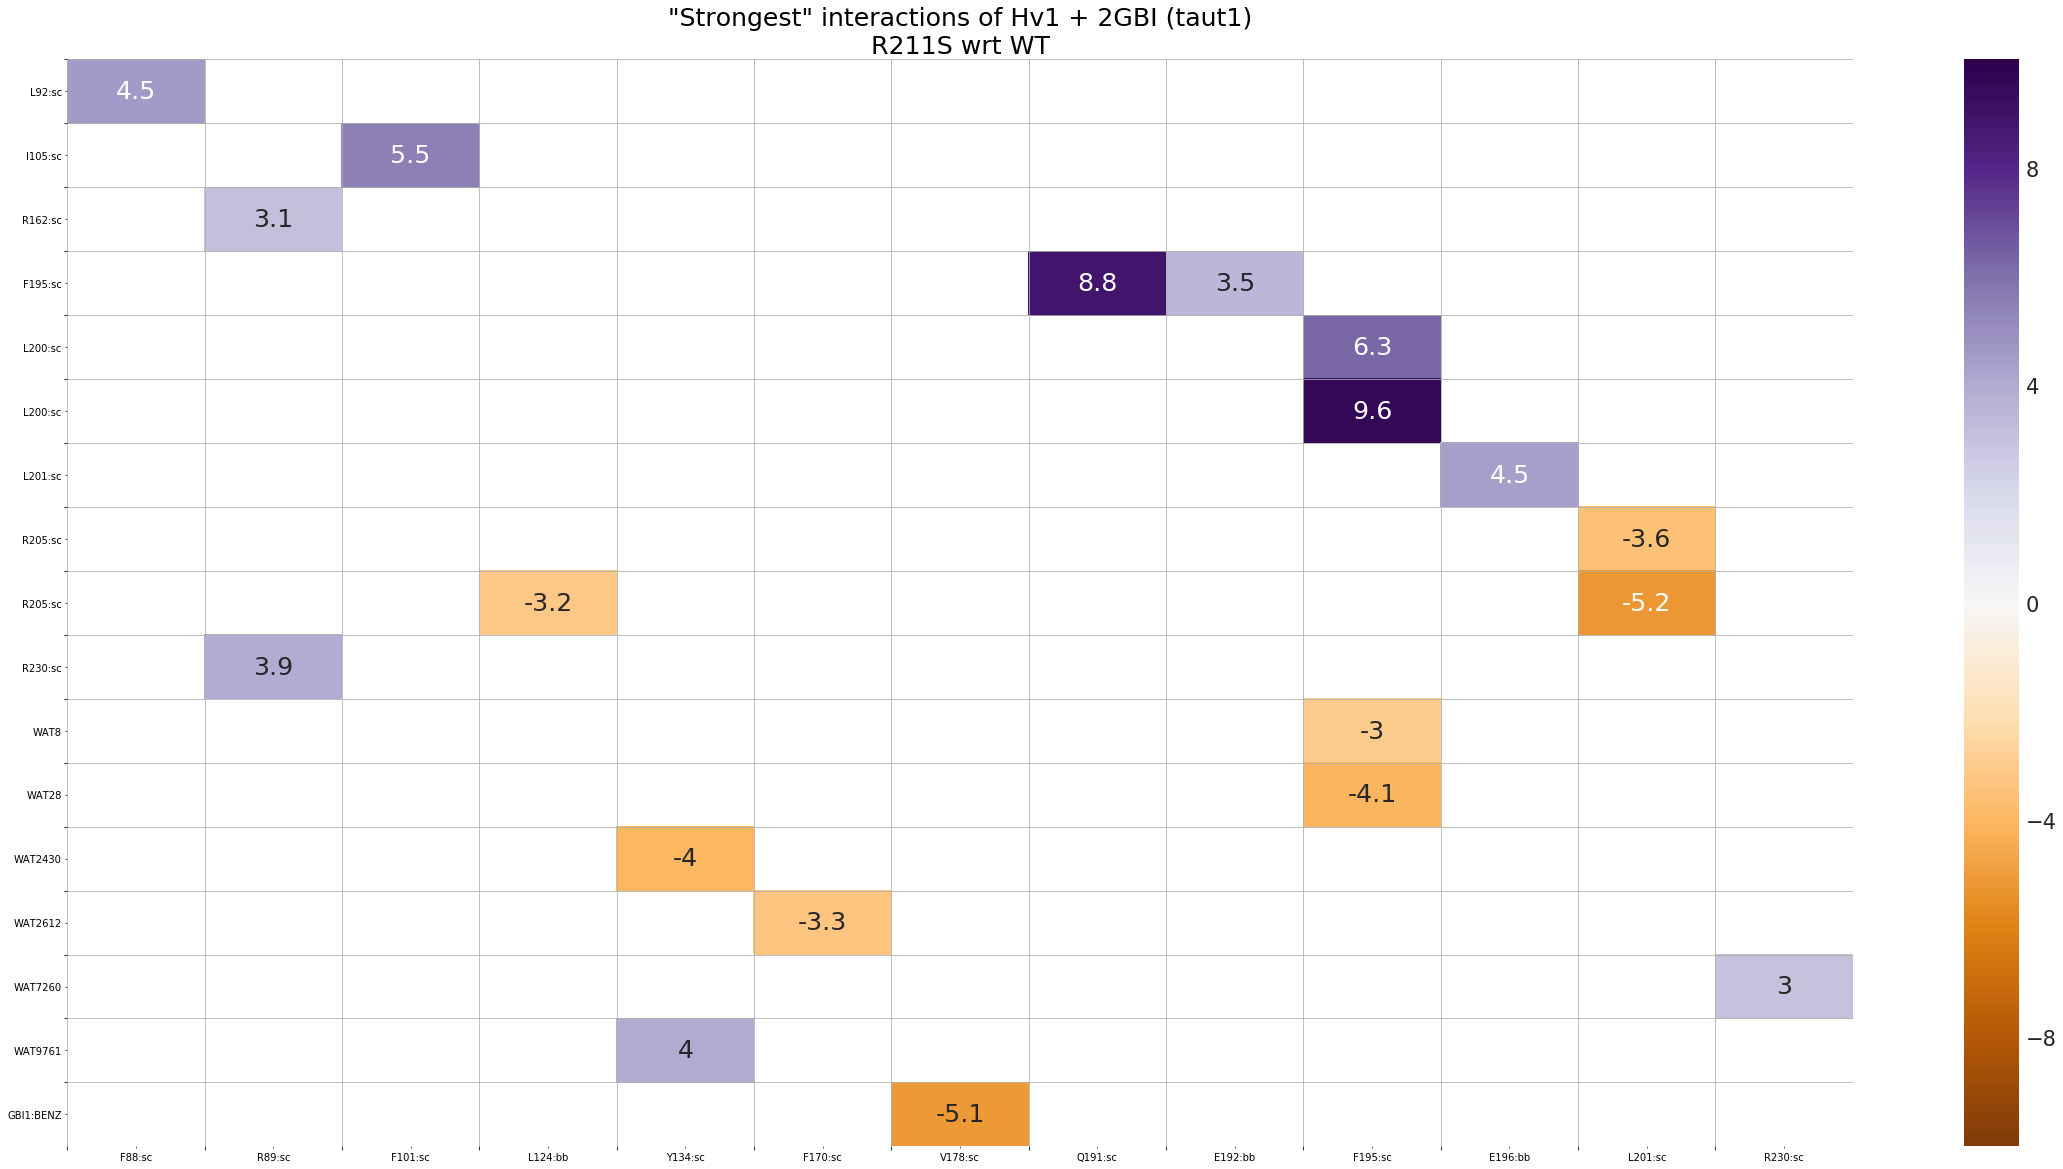

interaction range is from -10 to 10; verify if this is appropriate


In [15]:
diff_nodes_1, diff_edges_1, mutstart_1, offset_1 = diffEdges(nodes_1,wt_nodes_1,edges_1,wt_edges_1)
watless_diff_edges_1 = protLigInts(diff_nodes_1, diff_edges_1,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_1, watless_diff_edges_1, minHeat=-10, maxHeat=10,colors='PuOr',size=(40,20),seltitle="Hv1 + 2GBI (taut1)\nR211S wrt WT")

nodes in 1st, not in 2nd:  [381 382 383 384]
nodes in 2nd, not in 1st:  [381 382 383]
Shifting node indices by 1 for 809198 rows


/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


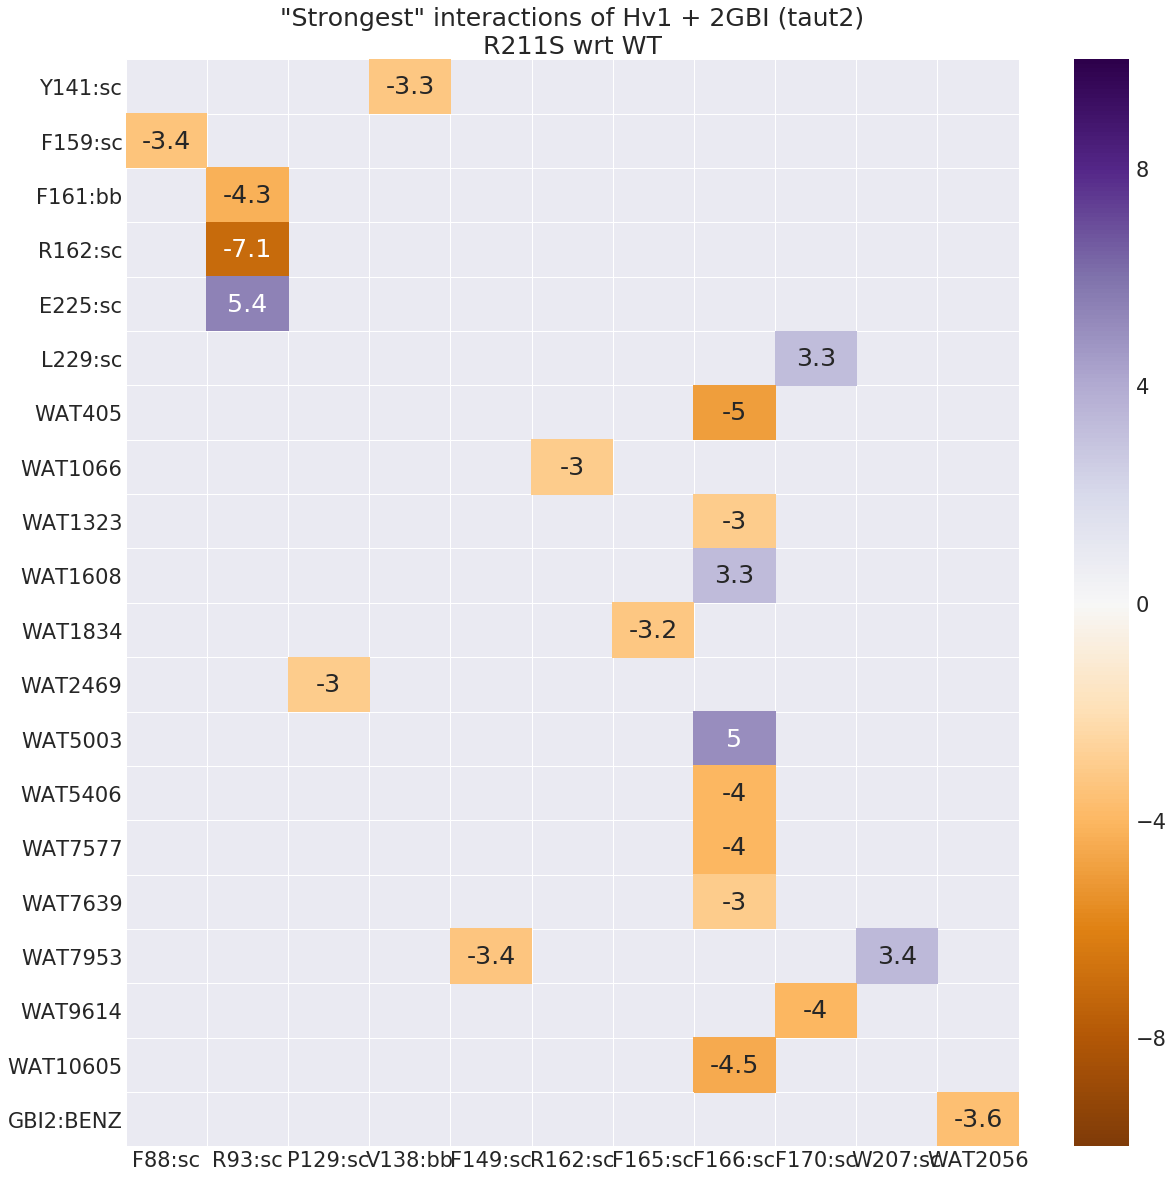

interaction range is from -10 to 10; verify if this is appropriate


In [16]:
diff_nodes_2, diff_edges_2, mutstart_2, offset_2 = diffEdges(nodes_2,wt_nodes_2,edges_2,wt_edges_2)
watless_diff_edges_2 = protLigInts(diff_nodes_2, diff_edges_2,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_2, watless_diff_edges_2, minHeat=-10, maxHeat=10,colors='PuOr',seltitle="Hv1 + 2GBI (taut2)\nR211S wrt WT")

## B. Focus on ligand-specific interactions

### 1. Tautomer 1

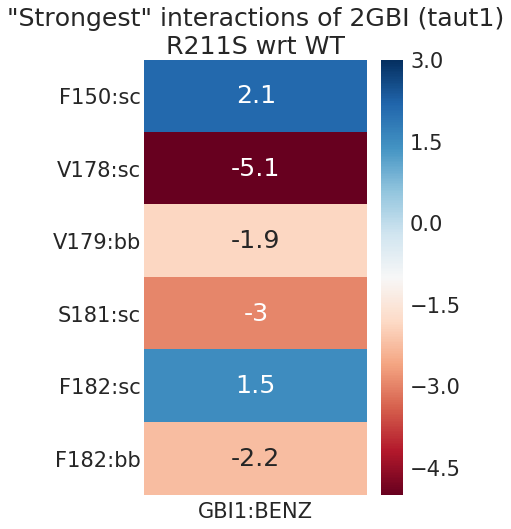

interaction range is from -5 to 3; verify if this is appropriate


In [17]:
# taut1 analysis (after-before) mutation
diff_gidx_1 = diff_nodes_1.index[diff_nodes_1['resname'] == 'GBI1'].tolist()
diff_gbi1_edges = selectionInts(diff_nodes_1, diff_edges_1, diff_gidx_1,rawNum=10)
plotHeatInts(diff_nodes_1,diff_gbi1_edges,minHeat=-5,maxHeat=3,colors="RdBu",size=(5,8),seltitle='2GBI (taut1)\nR211S wrt WT')

In [18]:
# taut1 analysis after mutation
gidx_1 = nodes_1.index[nodes_1['resname'] == 'GBI1'].tolist()
s211_gbi1_edges = selectionInts(nodes_1, edges_1, gidx_1,rawNum=1000)
#plotHeatInts(nodes_1,s211_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut1)\nafter R211S')

In [19]:
# taut1 analysis before mutation
wt_gidx_1 = wt_nodes_1.index[wt_nodes_1['resname'] == 'GBI1'].tolist()
r211_gbi1_edges = selectionInts(wt_nodes_1, wt_edges_1, wt_gidx_1,rawNum=1000)
#plotHeatInts(wt_nodes_1,r211_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut1)\nbefore R211S')

node_i's in common:  [11232 11233]
node_j's in common:  [ 76  77 180 181 185 189 191 192 193 196 200 201 202 204 205 206 213 214
 282 285 288 289 291 292 293 296 300 301 302]


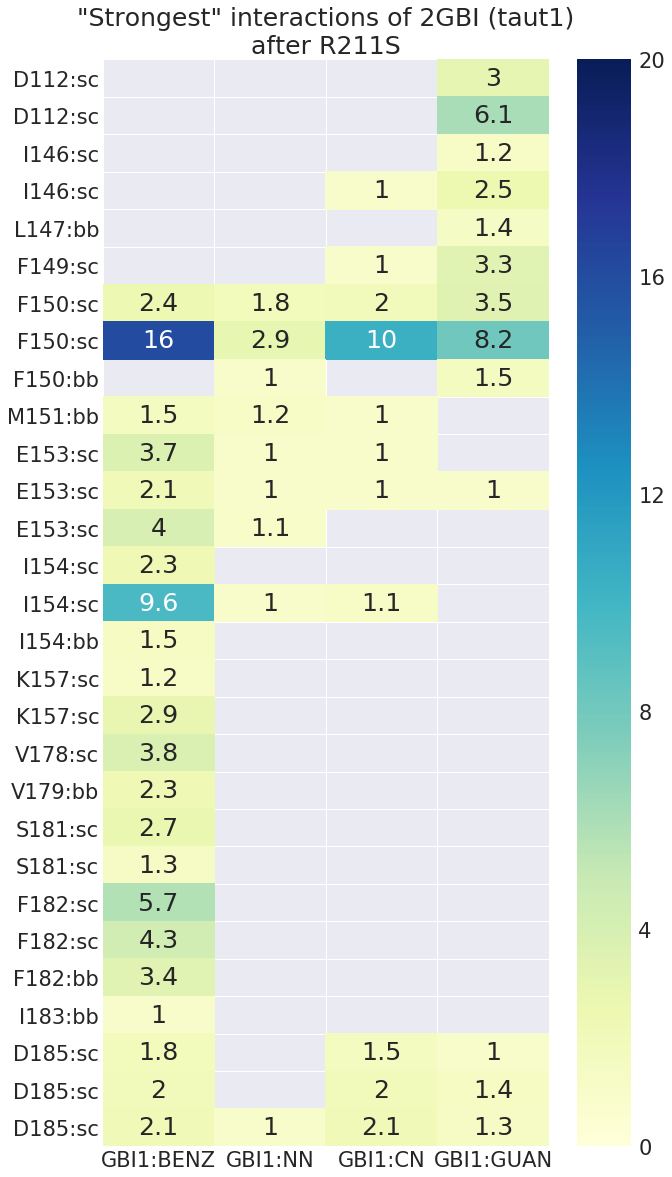

interaction range is from 0 to 20; verify if this is appropriate


In [20]:
sim_s211_gbi1_edges, sim_r211_gbi1_edges = similarizeTwoEdges(s211_gbi1_edges, r211_gbi1_edges, mutstart=381, offset=1)
plotHeatInts(nodes_1,sim_s211_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut1)\nafter R211S')

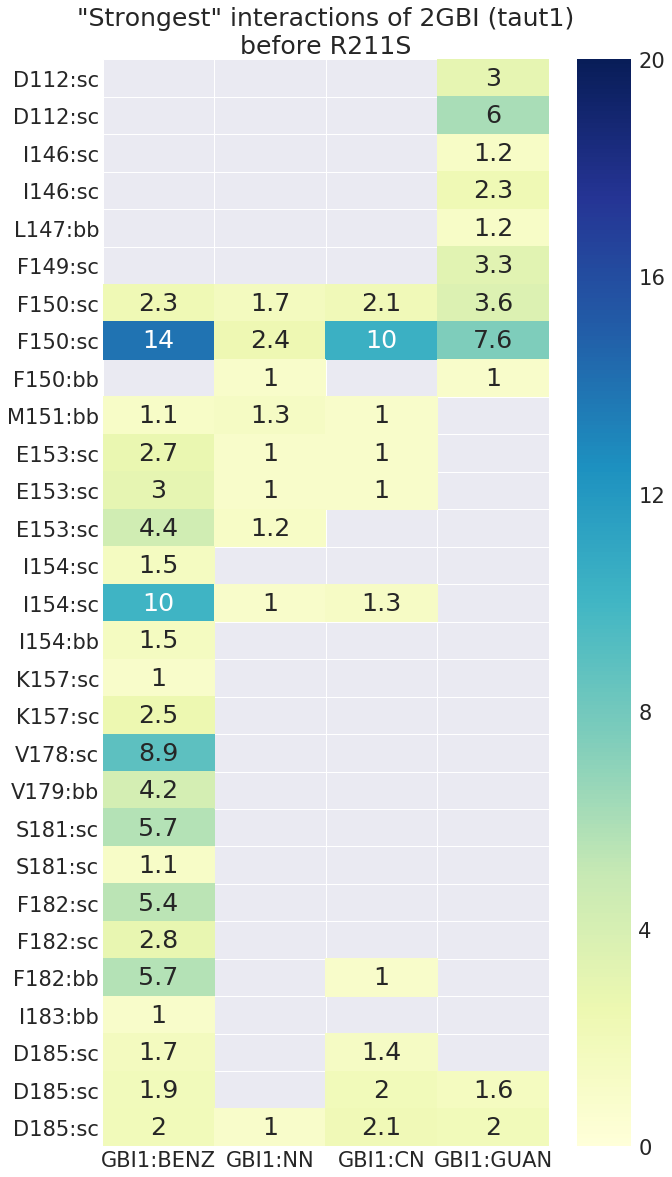

interaction range is from 0 to 20; verify if this is appropriate


In [21]:
plotHeatInts(wt_nodes_1,sim_r211_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut1)\nbefore R211S')

### 2. Tautomer 2

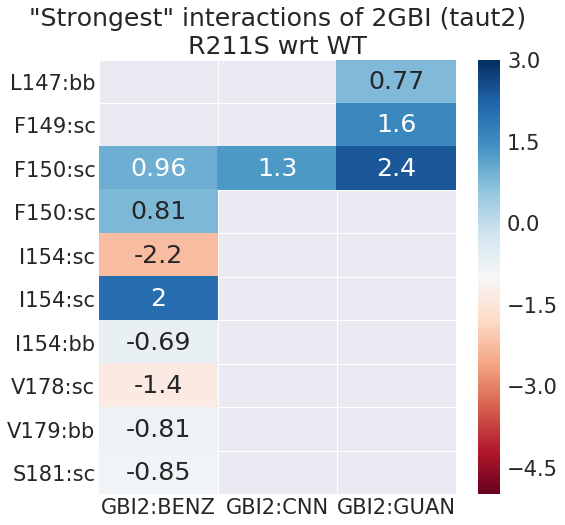

interaction range is from -5 to 3; verify if this is appropriate


In [22]:
# taut2 analysis (after-before) mutation
diff_gidx_2 = diff_nodes_2.index[diff_nodes_2['resname'] == 'GBI2'].tolist()
diff_gbi2_edges = selectionInts(diff_nodes_2, diff_edges_2, diff_gidx_2,rawNum=20)
plotHeatInts(diff_nodes_2,diff_gbi2_edges,minHeat=-5,maxHeat=3,colors="RdBu",size=(8,8),seltitle='2GBI (taut2)\nR211S wrt WT')

In [23]:
# taut2 analysis after mutation
gidx_2 = nodes_2.index[nodes_2['resname'] == 'GBI2'].tolist()
s211_gbi2_edges = selectionInts(nodes_2, edges_2, gidx_2,rawNum=1000)
#plotHeatInts(nodes_2,s211_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut2)\nafter R211S')

In [24]:
# taut2 analysis before mutation
wt_gidx_2 = wt_nodes_2.index[wt_nodes_2['resname'] == 'GBI2'].tolist()
r211_gbi2_edges = selectionInts(wt_nodes_2, wt_edges_2, wt_gidx_2,rawNum=1000)
#plotHeatInts(wt_nodes_2,r211_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut2)\nbefore R211S')

node_i's in common:  [11229]
node_j's in common:  [ 75  76  77 180 181 185 189 191 192 193 196 200 201 202 204 206 214 215
 282 285 288 289 291 292 296 300 301 302]


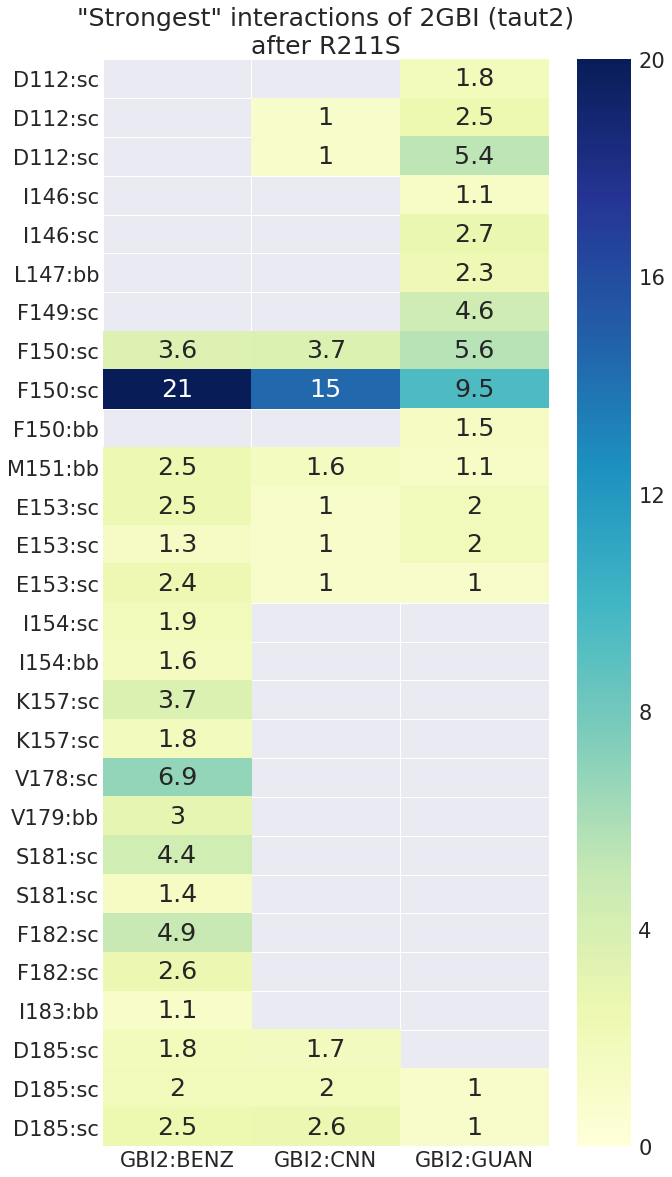

interaction range is from 0 to 20; verify if this is appropriate


In [25]:
sim_s211_gbi2_edges, sim_r211_gbi2_edges = similarizeTwoEdges(s211_gbi2_edges, r211_gbi2_edges, mutstart=381, offset=1)
plotHeatInts(nodes_2,sim_s211_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut2)\nafter R211S')

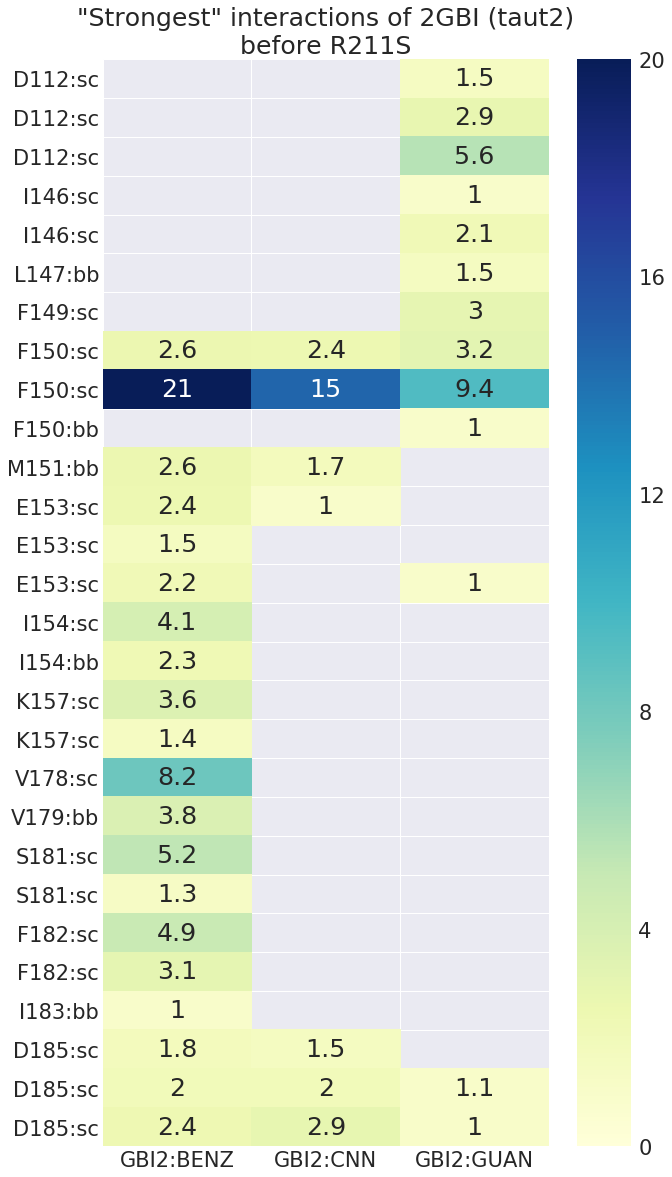

interaction range is from 0 to 20; verify if this is appropriate


In [26]:
plotHeatInts(wt_nodes_2,sim_r211_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),seltitle='2GBI (taut2)\nbefore R211S')

### 3. No ligand

[placeholder]

## C. Focus on other defined interactions

In [27]:
selNodes_112 = getResidInfo(112, nodes_2, resExcludes=['WAT'])
selInds_112 = selNodes_112.index.tolist()
print(selInds_112)
selNodes_112

[75, 76, 77, 78]


,resname,resid,location,type,code,nAtoms
index,,,,,,
75,ASP,112,sc,NOP,AB,2
76,ASP,112,sc,NOP,G,1
77,ASP,112,sc,NEG,D,2
78,ASP,112,bb,DIP,BB,3


In [28]:
selectionInts(nodes_1, edges_1, selInds_112)
#seltitle='D112\n(with taut1, after R211S)',maxvalue=10)

node_j,68,69,70,71,72,73,74,79,80,81,82,83,84,86,180,181,189,11233
node_i,,,,,,,,,,,,,,,,,,
75,2.211155,4.195219,NaN,4.000000,3.737052,NaN,3.780876,3.729084,5.000000,NaN,NaN,1.892430,1.944223,NaN,1.825532,5.948207,2.075117,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.940239,2.000000,3.000000
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.278884,NaN,NaN,NaN,NaN,NaN,NaN,2.179283,1.693989,6.051793
78,NaN,4.143426,1.936255,4.904382,5.000000,6.239044,9.000000,3.490040,9.000000,4.0,2.137931,5.023904,4.043825,4.12749,NaN,4.812749,NaN,NaN


In [29]:
selNodes_185 = getResidInfo(185, nodes_2, resExcludes=['WAT'])
selInds_185 = selNodes_185.index.tolist()
selectionInts(nodes_1, edges_1, selInds_185)
#seltitle='D185\n(with taut1, after R211S)',maxvalue=10)

node_j,192,293,296,297,298,299,304,305,306,307,308,309,311,369,370,371,11230,11232
node_i,,,,,,,,,,,,,,,,,,
300,3.927711,3.663968,4.000000,3.215139,NaN,3.792829,3.501992,2.179916,5.00000,NaN,NaN,2.183267,NaN,NaN,NaN,2.364444,NaN,NaN
301,2.113636,1.988048,NaN,NaN,NaN,NaN,NaN,NaN,2.14741,NaN,NaN,NaN,NaN,NaN,NaN,2.119522,1.968127,1.996016
302,NaN,2.132000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.262948,2.063745,2.063745
303,NaN,3.828685,4.968127,5.000000,3.880478,9.000000,3.119522,NaN,9.00000,6.083665,4.940239,4.075697,4.155378,3.565737,2.972112,3.872510,NaN,NaN


# III. Analyze interactions differentiating tautomers

Protein + ligand interactions, with respect to tautomer 1.

## A. Focus on whole protein-ligand system

### 1. After mutation

nodes in 1st, not in 2nd:  [11227 11228 11229 11230 11231 11232 11233]
nodes in 2nd, not in 1st:  [11227 11228 11229]
Shifting node indices by 4 for 0 rows


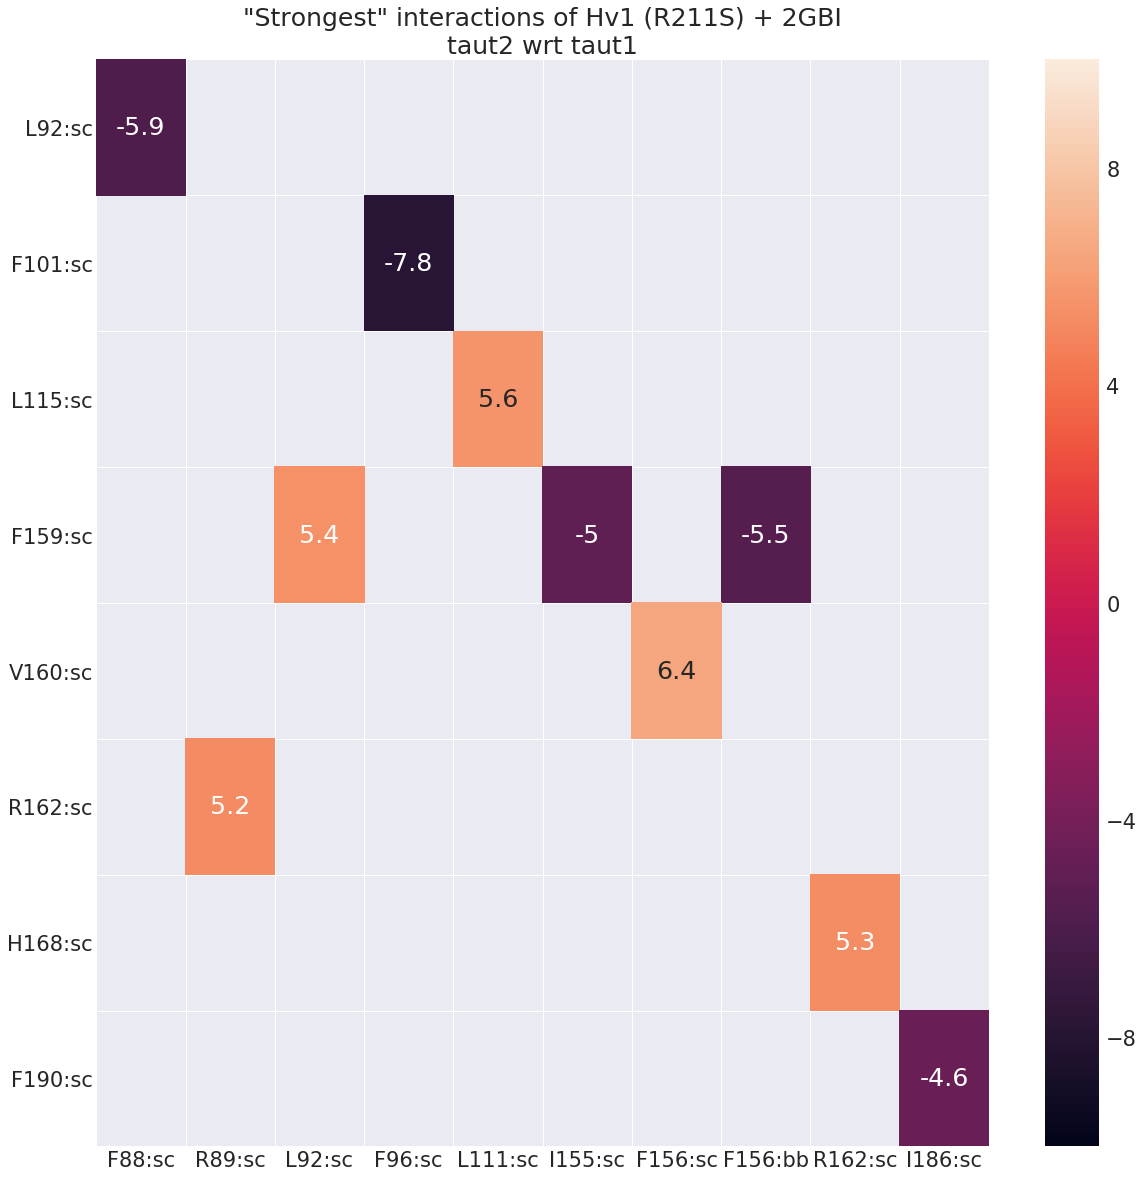

interaction range is from -10 to 10; verify if this is appropriate


In [30]:
diff_nodes_21, diff_edges_21, mutstart_21, offset_21 = diffEdges(nodes_2,nodes_1,edges_2,edges_1)
watless_diff_edges_21 = protLigInts(diff_nodes_21, diff_edges_21,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_21, watless_diff_edges_21, minHeat=-10, maxHeat=10, seltitle="Hv1 (R211S) + 2GBI\ntaut2 wrt taut1")

nodes in 1st, not in 2nd:  [11230 11231 11232 11233]
nodes in 2nd, not in 1st:  [11230 11231 11232 11233]
Shifting node indices by 0 for 0 rows


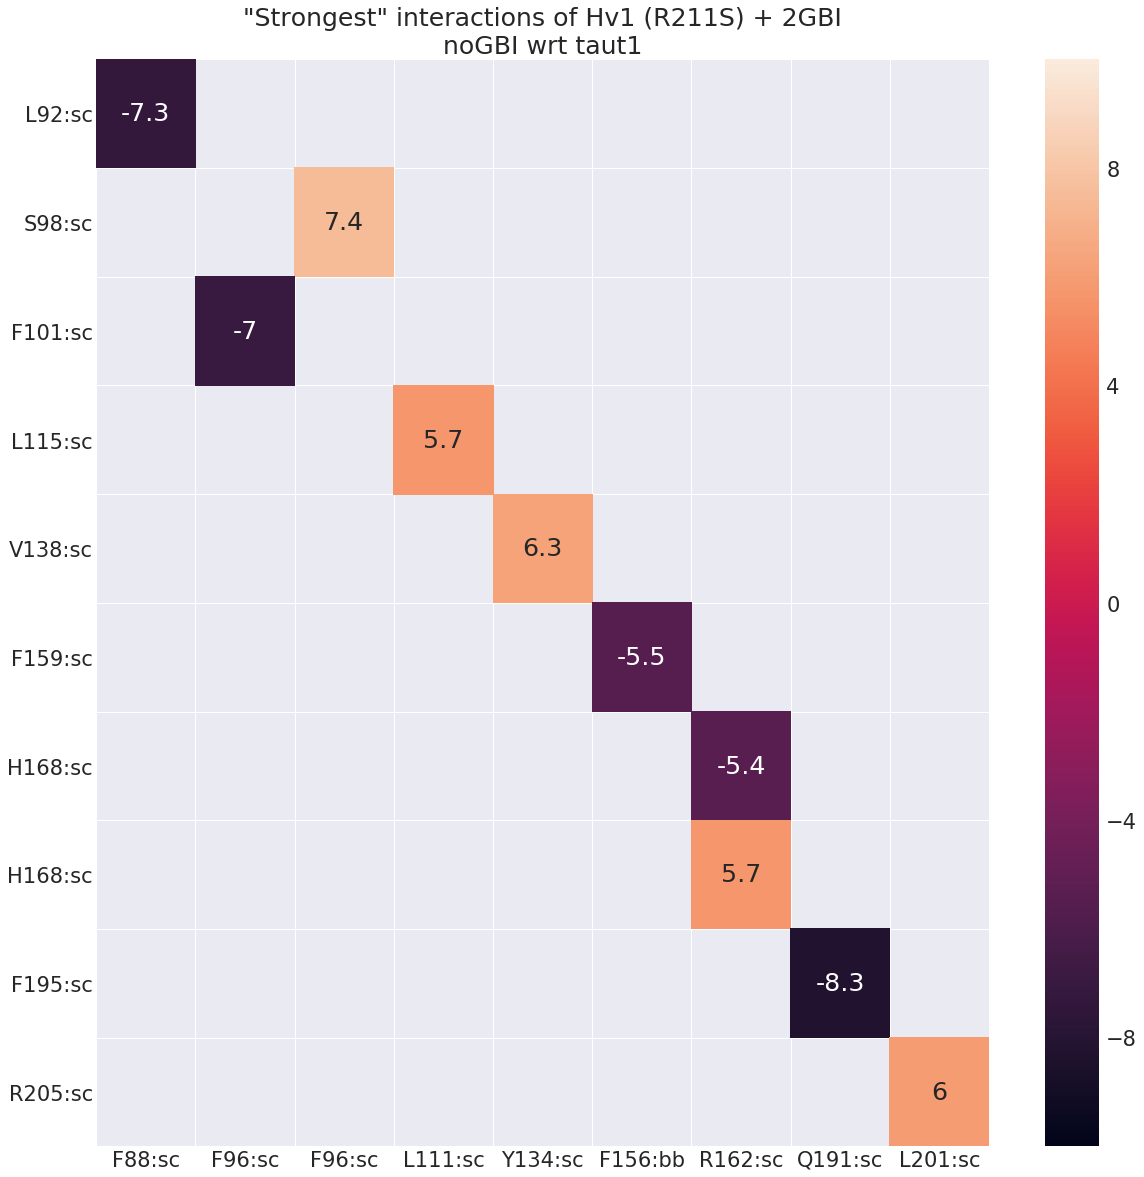

interaction range is from -10 to 10; verify if this is appropriate


In [31]:
diff_nodes_01, diff_edges_01, mutstart_01, offset_01 = diffEdges(nodes_0,nodes_1,edges_0,edges_1)
watless_diff_edges_01 = protLigInts(diff_nodes_01, diff_edges_01,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_01, watless_diff_edges_01, minHeat=-10, maxHeat=10, seltitle="Hv1 (R211S) + 2GBI\nnoGBI wrt taut1")

### 2. Before mutation

[placeholder]

## B. Focus on ligand-specific interactions

### 1. After mutation

[placeholder]

### 2. Before mutation

[placeholder]

# IV. Analyze interactions directly from computed edges

In other words, absolute interactions not with respect to anything.  
NOTE: Right now, I'm not sure how to interpret these heat maps well or how to make them more useful.

## A. Focus on whole protein-ligand system

### 1. After mutation

#### a. Tautomer 1

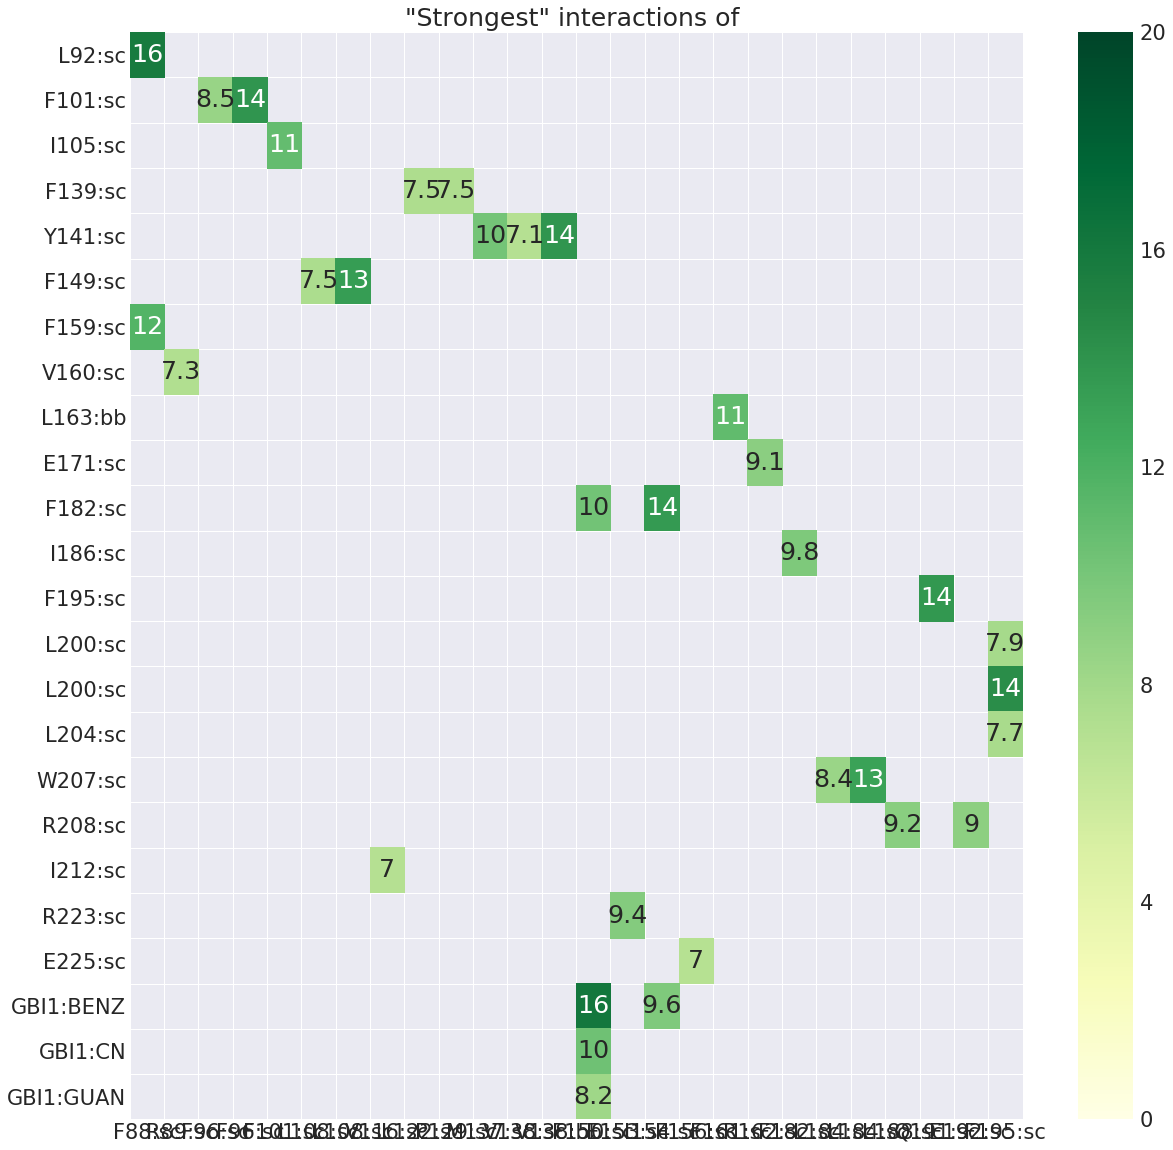

interaction range is from 0 to 20; verify if this is appropriate


In [32]:
# taut1
watless_edges_1 = protLigInts(nodes_1, edges_1)
plotHeatInts(nodes_1,watless_edges_1,minHeat=0,maxHeat=20,colors="YlGn")

#### b. Tautomer 2

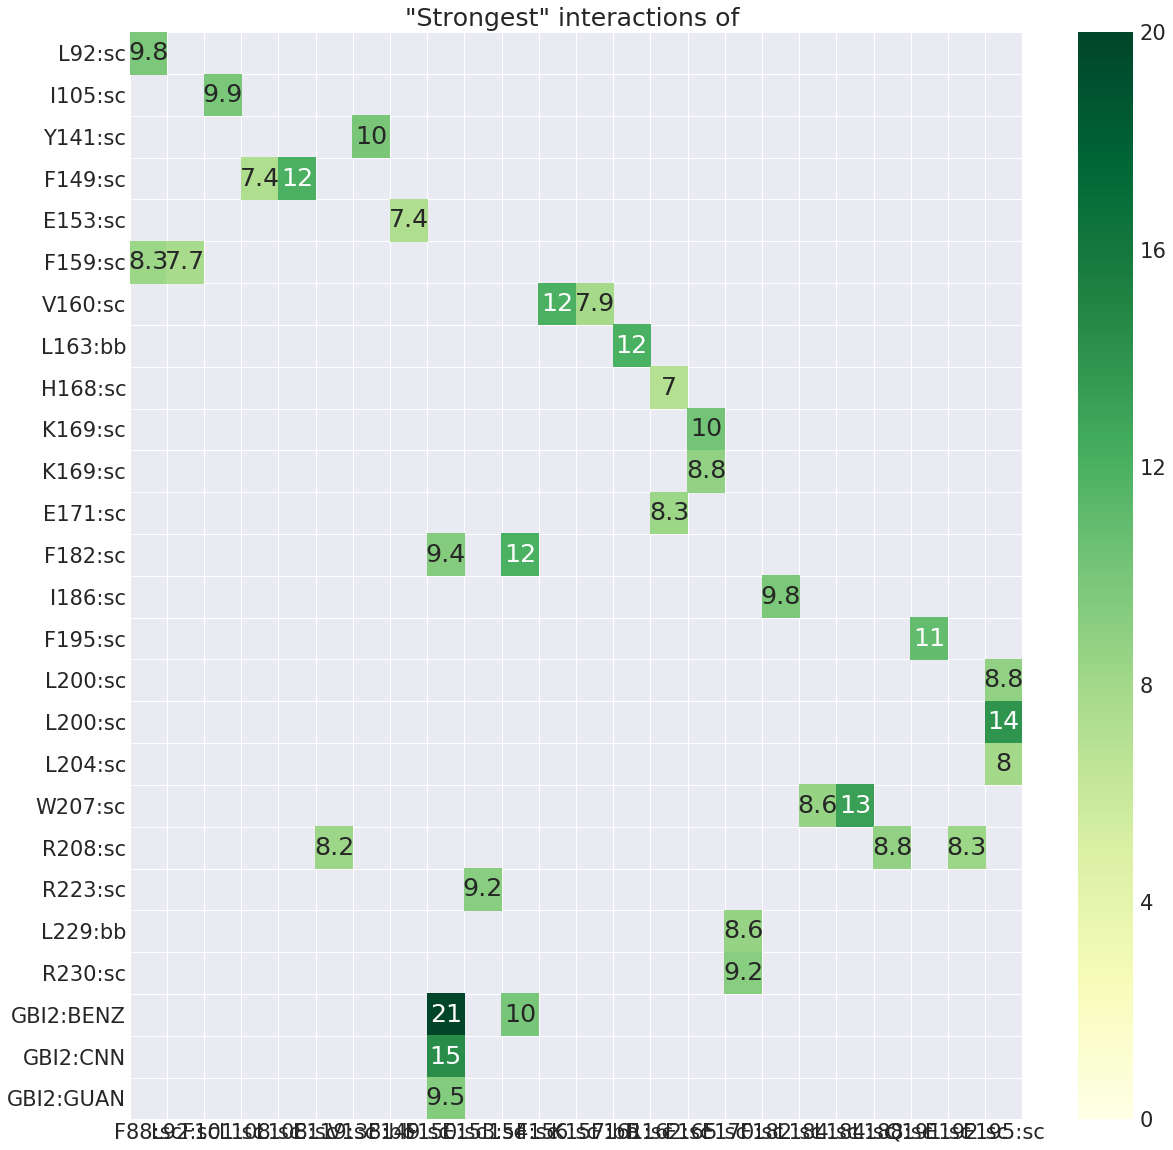

interaction range is from 0 to 20; verify if this is appropriate


In [33]:
# taut2
watless_edges_2 = protLigInts(nodes_2, edges_2)
plotHeatInts(nodes_2,watless_edges_2,minHeat=0,maxHeat=20,colors="YlGn")

### 2. Before mutation

[placeholder]

# Troubleshooting

In [ ]:
for i, (index, row) in enumerate(diff_edges_1.iterrows()):
    print('\n ',i,row['node_i'],row['node_j'])
    print(idxToResid(row['node_i'], diff_nodes_1), idxToResid(row['node_j'], diff_nodes_1))

In [35]:
diff_edges_1.iloc[6955]

node_i            369
node_j            379
weight_x          674
attribute       HPHOB
count_x           251
average_x     2.68526
weight_y          661
count_y           250
average_y       2.644
avg_subt     0.041259
Name: 6955, dtype: object

In [36]:
idxToResid(369, diff_nodes_1)

'W207:sc'

In [37]:
diff_edges_1.head()

,node_i,node_j,weight_x,attribute,count_x,average_x,weight_y,count_y,average_y,avg_subt
0,1,3,467,STER,251.0,1.860558,439,250.0,1.756,0.104558
1,1,4,231,STER,231.0,1.000000,187,187.0,1.000,0.000000
2,1,5,5,STER,5.0,1.000000,2,2.0,1.000,0.000000
3,1,7,753,HBOND,251.0,3.000000,750,250.0,3.000,0.000000
4,1,9,31,HBOND,31.0,1.000000,87,87.0,1.000,0.000000


In [38]:
diff_nodes_1.iloc[365:385]

,resname,resid,location,type,code,nAtoms
index,,,,,,
366,LEU,206,sc,NOP,AB,2
367,LEU,206,sc,NOP,GD,3
368,LEU,206,bb,DIP,BB,3
369,TRP,207,sc,NOP,ABGD,4
370,TRP,207,sc,DIP,E,1
371,TRP,207,sc,NOP,EZH,6
372,TRP,207,bb,DIP,BB,3
373,ARG,208,sc,NOP,AB,2
374,ARG,208,sc,NOP,GD,2


In [39]:
findInEdges(380,diff_edges_1)

,node_i,node_j,weight_x,attribute,count_x,average_x,weight_y,count_y,average_y,avg_subt
6934,366,380,88,STER,88.0,1.000000,27,27.0,1.000000,0.000000
6956,369,380,285,STER,193.0,1.476684,303,203.0,1.492611,-0.015927
6969,372,380,1054,HBOND,251.0,4.199203,1049,250.0,4.196000,0.003203
6975,373,380,494,STER,251.0,1.968127,493,250.0,1.972000,-0.003873
6989,376,380,1217,HBOND,251.0,4.848606,1245,250.0,4.980000,-0.131394
6992,377,380,2526,STER,251.0,10.063745,2517,250.0,10.068000,-0.004255
7000,378,380,2259,HBOND,251.0,9.000000,2250,250.0,9.000000,0.000000
7004,379,380,1255,STER,251.0,5.000000,1250,250.0,5.000000,0.000000
7012,380,385,1004,STER,251.0,4.000000,1000,250.0,4.000000,0.000000
7013,380,386,925,STER,251.0,3.685259,933,249.0,3.746988,-0.061729


In [40]:
edges_1[(edges_1.attribute == 'STER') & (edges_1.weight == 1865)]

,node_i,node_j,weight,attribute,count,average
72103,413,419,1865,STER,251.0,7.430279


In [41]:
wt_edges_1[(wt_edges_1.attribute == 'HBOND') & (wt_edges_1.weight == 7) & (wt_edges_1.node_i == 413)]

,node_i,node_j,weight,attribute,count,average
82685,413,415,7,HBOND,7.0,1.000000
82688,413,420,7,HBOND,7.0,1.000000
82778,413,6374,7,HBOND,3.0,2.333333
82801,413,7460,7,HBOND,6.0,1.166667
82822,413,8490,7,HBOND,3.0,2.333333
82840,413,9762,7,HBOND,3.0,2.333333
